# Capstone Project 2 - Part 1

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pickle
from warnings import simplefilter
# fix the warning problem in jupyter notebook
import warnings
warnings.filterwarnings('ignore')

In [6]:
# load the csv files of 'customers', 'order_items', 'order_payments','order_review','customer' into dataframes
customers=pd.read_csv('C:\A\Education\Data Science\Capstone project 2\Dataset\olist_customers_dataset.csv')
order_items=pd.read_csv('C:\A\Education\Data Science\Capstone project 2\Dataset\olist_order_items_dataset.csv')
order_payments=pd.read_csv('C:\A\Education\Data Science\Capstone project 2\Dataset\olist_order_payments_dataset.csv')
order_reviews=pd.read_csv('C:\A\Education\Data Science\Capstone project 2\Dataset\olist_order_reviews_dataset.csv')
orders=pd.read_csv('C:\A\Education\Data Science\Capstone project 2\Dataset\olist_orders_dataset.csv')

In [7]:
customers.shape

(99441, 5)

In [8]:
customers.groupby('customer_unique_id').count().shape

(96096, 4)

In [9]:
# convert 'order_purchase_timestamp_day' to datetime format and extract the date value
orders['order_purchase_timestamp_day'] = pd.to_datetime(orders['order_purchase_timestamp']).dt.date
print(orders['order_purchase_timestamp_day'])

0        2017-10-02
1        2018-07-24
2        2018-08-08
3        2017-11-18
4        2018-02-13
5        2017-07-09
6        2017-04-11
7        2017-05-16
8        2017-01-23
9        2017-07-29
10       2017-05-16
11       2017-07-13
12       2018-06-07
13       2018-07-25
14       2018-03-01
15       2018-06-07
16       2018-01-02
17       2017-12-26
18       2017-11-21
19       2017-10-26
20       2017-09-18
21       2018-03-15
22       2018-02-03
23       2018-01-08
24       2018-08-09
25       2018-02-20
26       2018-06-04
27       2018-03-12
28       2018-05-02
29       2018-02-25
            ...    
99411    2018-07-22
99412    2017-11-26
99413    2018-04-01
99414    2017-08-10
99415    2017-10-10
99416    2018-06-03
99417    2018-02-07
99418    2017-11-30
99419    2017-10-02
99420    2017-06-07
99421    2017-07-05
99422    2018-05-25
99423    2017-10-12
99424    2017-11-21
99425    2018-03-21
99426    2017-05-15
99427    2018-05-12
99428    2018-06-22
99429    2017-11-05


In [10]:
# count number of order for each day
new_orders = orders.groupby('order_purchase_timestamp_day').count()['order_id'].reset_index().rename(columns = {'order_id':'order_count'})
new_orders.tail()

,order_purchase_timestamp_day,order_count
629,2018-09-29,1
630,2018-10-01,1
631,2018-10-03,1
632,2018-10-16,1
633,2018-10-17,1


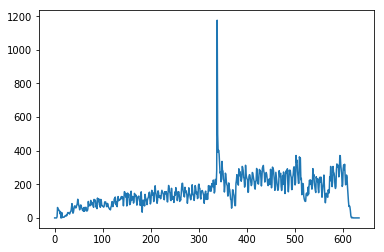

In [11]:
# plot the column of order_count, there is an outlier and the data between 100 to 600 rows are more
# suitable to use for modeling
plt.plot(new_orders['order_count'])

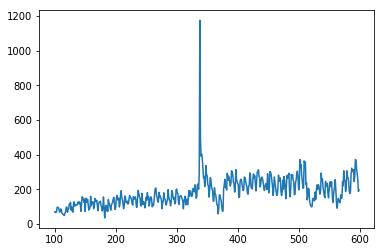

In [12]:
plt.plot(new_orders[100:600]['order_count'])

In [13]:
# create a new dataframe for 100-600 rows
df=new_orders[100:600]

In [14]:
# look for the value of outlier
df['order_count'].describe()

count     500.00000
mean      181.64800
std        84.78016
min        35.00000
25%       124.75000
50%       165.00000
75%       230.25000
max      1176.00000
Name: order_count, dtype: float64

In [37]:
# drop the outlier, order_count=1176
df.drop( df[df['order_count'] == 1176 ].index, inplace=True)
df.describe()

,order_count
count,498.000000
mean,179.014056
std,70.835015
min,35.000000
25%,124.250000
50%,165.000000
75%,229.750000
max,403.000000


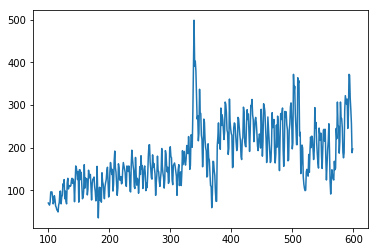

In [16]:
# re-plot order_count
plt.plot(df['order_count'])

In [17]:
# order_count= 499 seems like another outlier, therefore drop it
df.drop( df[df['order_count'] == 499 ].index, inplace=True)

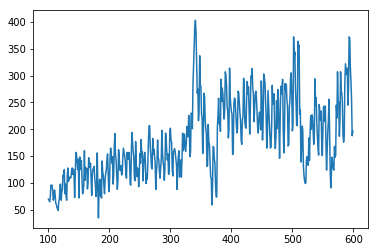

In [18]:
# re-plot order_count
plt.plot(df['order_count'])

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 498 entries, 100 to 599
Data columns (total 2 columns):
order_purchase_timestamp_day    498 non-null object
order_count                     498 non-null int64
dtypes: int64(1), object(1)
memory usage: 11.7+ KB


In [20]:
# convert df into time series
df = df.set_index('order_purchase_timestamp_day')

In [21]:
print(df)

                              order_count
order_purchase_timestamp_day             
2017-03-31                             70
2017-04-01                             68
2017-04-02                             65
2017-04-03                             72
2017-04-04                             96
2017-04-05                             96
2017-04-06                             96
2017-04-07                             85
2017-04-08                             68
2017-04-09                             73
2017-04-10                             87
2017-04-11                             78
2017-04-12                             63
2017-04-13                             60
2017-04-14                             54
2017-04-15                             52
2017-04-16                             49
2017-04-17                             65
2017-04-18                             71
2017-04-19                             97
2017-04-20                             98
2017-04-21                        

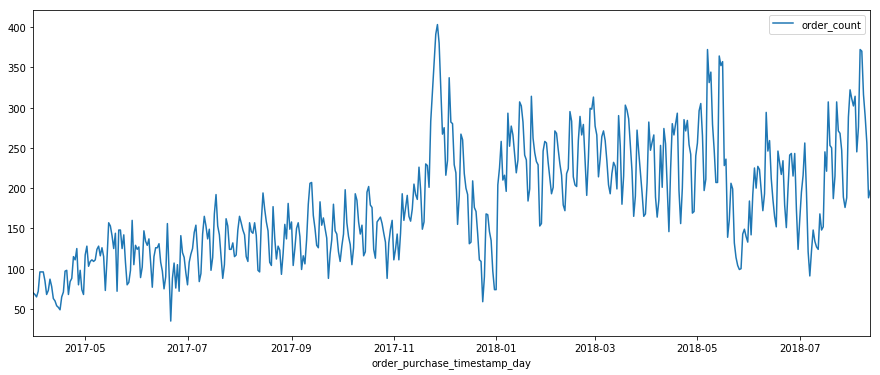

In [22]:
# visualize the data, see if there is any seasonal pattern
df.plot(figsize=(15, 6))
plt.show()

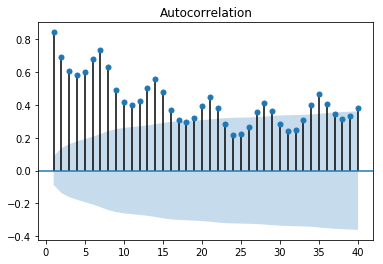

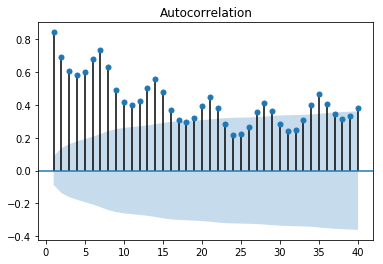

In [23]:
# plot ACF to discover the seasonality, it looks that the seasonal pattern occur every 7 days
# (weekly), therefore, I set the 'freq' parameter as 7. Using 0.5 as cut off, the autocorrelation
# of the first 8 lags are higher than that, therefore, I set the parameter P=7 for SARIMAX (tried)
# P=8 first but resulted in strong correlation problem
sm.graphics.tsa.plot_acf(df['order_count'], zero=False,lags=40)

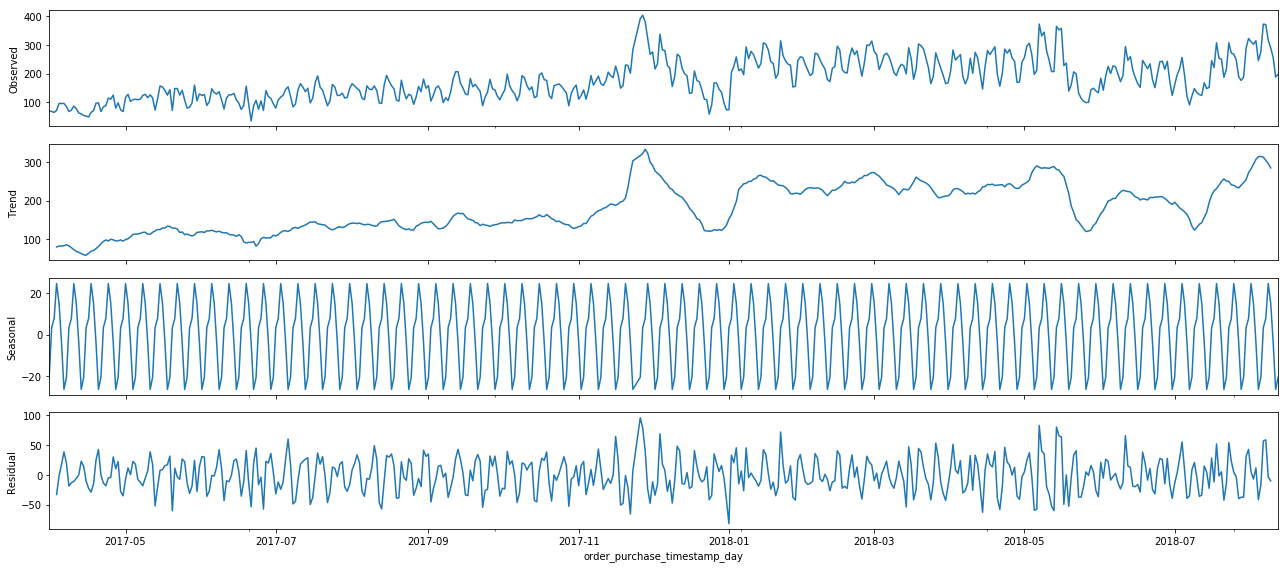

In [24]:
# decompose the time series
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(df,freq=7)
fig = decomposition.plot()
plt.show()

In [25]:
#extract trend data from seasonal decomposition
trend=decomposition.trend
print(trend)

                              order_count
order_purchase_timestamp_day             
2017-03-31                            NaN
2017-04-01                            NaN
2017-04-02                            NaN
2017-04-03                      80.428571
2017-04-04                      82.571429
2017-04-05                      82.571429
2017-04-06                      83.714286
2017-04-07                      85.857143
2017-04-08                      83.285714
2017-04-09                      78.571429
2017-04-10                      73.428571
2017-04-11                      69.000000
2017-04-12                      66.714286
2017-04-13                      63.285714
2017-04-14                      60.142857
2017-04-15                      59.142857
2017-04-16                      64.000000
2017-04-17                      69.428571
2017-04-18                      71.428571
2017-04-19                      76.000000
2017-04-20                      81.571429
2017-04-21                      88

In [26]:
# drop missing value and export dataframe to excel file
trend=trend.dropna()
trend.to_excel(r"C:\A\Education\Data Science\Capstone project 2\trenddata.xlsx")

In [27]:
#split train (first 398 row, 80% of the dataset) and test dataset (the rest 20% of the dataset) 
df_train=df.iloc[:398]
df_test=df.iloc[398:]
print(df_train,df_test)

                              order_count
order_purchase_timestamp_day             
2017-03-31                             70
2017-04-01                             68
2017-04-02                             65
2017-04-03                             72
2017-04-04                             96
2017-04-05                             96
2017-04-06                             96
2017-04-07                             85
2017-04-08                             68
2017-04-09                             73
2017-04-10                             87
2017-04-11                             78
2017-04-12                             63
2017-04-13                             60
2017-04-14                             54
2017-04-15                             52
2017-04-16                             49
2017-04-17                             65
2017-04-18                             71
2017-04-19                             97
2017-04-20                             98
2017-04-21                        

In [28]:
# define train_model function to train the SARIMAX model with first 80% of the data and 
# perform one step ahead forecast for the rest of 20%. For example: first df_train is
# 0~397(n=0), second dr_train is 0~398(n=1),etc.
# For the SARIMAX model, P=7 according to above analysis, D=2 (2 degree function based on 
# excel search, Q=1 (will tune this parameter later), S=7.
# use Symmetric Mean Absolute Percentage Error (SMAPE) to measure the performance of the model
def train_model(n):
    # create empty list for error
    error_list=[]
    #iterate n times to get n predicted values
    for i in range(n):
        # split training dataset
        df_train=df.iloc[:398+i]
        # instantiate SARIMAX model, P=7, D=2, Q=1, S=7 
        model=SARIMAX(df_train,seasonal_order=(7,2,1,7),enforce_stationarity=False,enforce_invertibility=False)
        # train the model
        model_fit=model.fit()
        # get one step ahead forecast
        model_fore=model_fit.forecast()
        #convert model_fit (series object) to array 
        fore=model_fore.array
        # get the predicted value from array
        fore_val=fore[0]
        # get the actual value
        actual_val=df.order_count.iloc[398+i]
        # calculate |Ft−At|/(Ft+At) 
        error=abs(fore_val-actual_val)/(fore_val+actual_val)
        error_list.append(error)
    # calculate smape
    smape=sum(error_list)/n
    print("base line smape:"+str(smape))
    

In [38]:
train_model(5)

base line smape:0.04311210669677118


In [32]:
# predict the last 20% of data and calcuate smape
train_model(100)

C:\A\Program\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\A\Program\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\A\Program\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\A\Program\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\A\Program\Anaconda\li

C:\A\Program\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\A\Program\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\A\Program\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\A\Program\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\A\Program\Anaconda\li

C:\A\Program\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\A\Program\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\A\Program\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\A\Program\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\A\Program\Anaconda\li

C:\A\Program\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\A\Program\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\A\Program\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\A\Program\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\A\Program\Anaconda\li

C:\A\Program\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\A\Program\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\A\Program\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\A\Program\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\A\Program\Anaconda\li

C:\A\Program\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\A\Program\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\A\Program\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\A\Program\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\A\Program\Anaconda\li

base line smape:0.06780275823213266


C:\A\Program\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [34]:
# define train_model function to train the SARIMAX model with first 80% of the data and 
# perform one step ahead forecast for the rest of 20%. For example: first df_train is
# 0~397(n=0), second dr_train is 0~398(n=1),etc.
# For the SARIMAX model, P=7 according to above analysis, D=2 (2 degree function based on 
# excel search, Q=1 (will tune this parameter later), S=7.
# use Symmetric Mean Absolute Percentage Error (SMAPE) to measure the performance of the model
def train_model_1(n):
    # create empty list for error
    error_list=[]
    #iterate n times to get n predicted values
    for i in range(n):
        # split training dataset
        df_train=df.iloc[:398+i]
        # instantiate SARIMAX model, P=7, D=2, Q=1, S=7 
        model=SARIMAX(df_train,seasonal_order=(7,1,1,7),enforce_stationarity=False,enforce_invertibility=False)
        # train the model
        model_fit=model.fit()
        # get one step ahead forecast
        model_fore=model_fit.forecast()
        #convert model_fit (series object) to array 
        fore=model_fore.array
        # get the predicted value from array
        fore_val=fore[0]
        # get the actual value
        actual_val=df.order_count.iloc[398+i]
        # calculate |Ft−At|/(Ft+At) 
        error=abs(fore_val-actual_val)/(fore_val+actual_val)
        error_list.append(error)
    # calculate smape
    smape=sum(error_list)/n
    print("base line smape:"+str(smape))

In [35]:
train_model_1(100)

C:\A\Program\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\A\Program\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\A\Program\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\A\Program\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\A\Program\Anaconda\li

C:\A\Program\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\A\Program\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\A\Program\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\A\Program\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\A\Program\Anaconda\li

C:\A\Program\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\A\Program\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\A\Program\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\A\Program\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\A\Program\Anaconda\li

C:\A\Program\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\A\Program\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\A\Program\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\A\Program\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\A\Program\Anaconda\li

C:\A\Program\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\A\Program\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\A\Program\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\A\Program\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\A\Program\Anaconda\li

C:\A\Program\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\A\Program\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\A\Program\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\A\Program\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\A\Program\Anaconda\li

base line smape:0.06623557575936946


C:\A\Program\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [31]:
# pickle the dataframe for data exploring
outfile = open('C:\A\Education\Data Science\Capstone project 2\dataframe','wb')
pickle.dump(df,outfile)
outfile.close()